# Customer Churn Prediction using Machine Learning
Dataset yang digunakan pada project ini merupakan dataset  **DQLab Telco**  dari salah satu modul project-based yang telah saya selesaikan di DQLab Academy.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import pickle
from pathlib import Path

In [2]:
sns.set(style='darkgrid')

## Load Data

In [3]:
pd.options.display.max_columns = 50

df_load = pd.read_csv('https://storage.googleapis.com/dqlab-dataset/dqlab_telco.csv')
df_load.shape

(7113, 22)

In [4]:
df_load.head()

,UpdatedAt,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,202006,45759018157,Female,0,Yes,No,1.0,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,202006,45557574145,Male,0,No,No,34.0,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,202006,45366876421,Male,0,No,No,2.0,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,202006,45779536532,Male,0,No,No,45.0,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,202006,45923787906,Female,0,No,No,2.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Data Cleansing

### Filter customerID
Berikut merupakan kriteria customerID (phone number) yang benar:
* Panjang karakter adalah 11-12.
* Terdiri dari Angka Saja, tidak diperbolehkan ada karakter selain angka
* Diawali dengan angka 45 2 digit pertama.

In [5]:
df_load['customerID'].nunique()

7017

In [6]:
df_load['valid_id'] = df_load['customerID'].astype(str).str.match(r'45\d{9,10}')
df_load = df_load[df_load['valid_id'] == True].drop('valid_id', axis=1)
df_load['customerID'].count()

7006

In [7]:
df_load['customerID'].is_unique

False

In [8]:
# Drop duplicate ID & sorted by Periode
df_load = df_load.sort_values('UpdatedAt', ascending = False).drop_duplicates('customerID')
print('Hasil jumlah ID Customer yang sudah dihilangkan duplikasinya (distinct) adalah',df_load['customerID'].count())

Hasil jumlah ID Customer yang sudah dihilangkan duplikasinya (distinct) adalah 6993


In [9]:
df_load['customerID'].is_unique

True

### Checking for Missing Values

In [10]:
df_load.isna().sum() 

UpdatedAt            0
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure              99
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges      26
TotalCharges        15
Churn               43
dtype: int64

#### Dropping all missing rows on column churn

In [11]:
df_load.dropna(subset=['Churn'], inplace=True)

#### Handling missing values with imputation
Diasumsikan data modeller meminta pengisian missing values dengan kriteria berikut:
* `Tenure` pihak data modeller meminta setiap rows yang memiliki missing values untuk Lama berlangganan di isi dengan 11
* Variable yang bersifat numeric selain `Tenure` di isi dengan median dari masing-masing variable tersebut

In [12]:
df_load['tenure'].fillna(11, inplace=True) 

list_collumns = ['MonthlyCharges', 'TotalCharges']
for column in list_collumns:
    median = df_load[column].median()
    df_load[column].fillna(median, inplace=True)
    
df_load.isna().sum() 

UpdatedAt           0
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### Find Outlier

Outlier atau pencilan dapat dideteksi dengan melihat Box Plot dari data tersebut

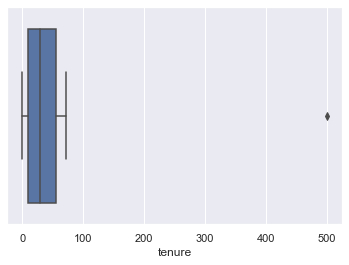

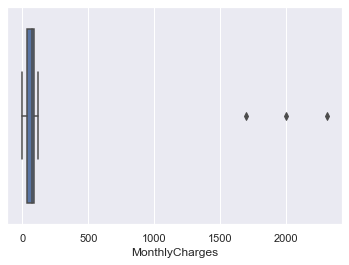

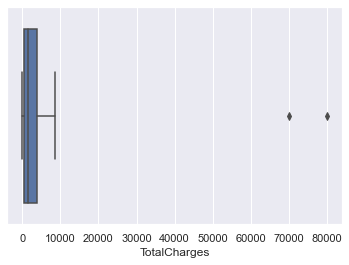

In [13]:
plt.figure()
sns.boxplot(x=df_load['tenure'])
plt.show()
plt.figure()
sns.boxplot(x=df_load['MonthlyCharges'])
plt.show()
plt.figure()
sns.boxplot(x=df_load['TotalCharges'])
plt.show()

#### Handling Outlier
Outlier dapat diatasi dengan menggunakan metode *interquartile range* (IQR)

In [14]:
Q1 = (df_load[['tenure', 'MonthlyCharges', 'TotalCharges']]).quantile(0.25)
Q3 = (df_load[['tenure', 'MonthlyCharges', 'TotalCharges']]).quantile(0.75)
IQR = Q3 - Q1

maximum = Q3 + (1.5*IQR)
minimum = Q1 - (1.5*IQR)

kondisi_more_than = (df_load > maximum)
kondisi_lower_than = (df_load < minimum)

In [15]:
df_load = df_load.mask(kondisi_more_than, maximum, axis=1)
df_load = df_load.mask(kondisi_lower_than, minimum, axis=1)

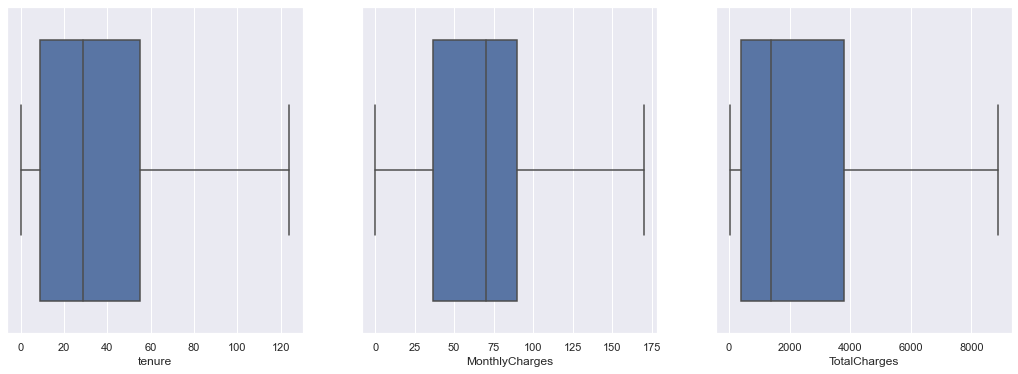

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
sns.boxplot(x=df_load['tenure'], ax=ax[0])
sns.boxplot(x=df_load['MonthlyCharges'], ax=ax[1])
sns.boxplot(x=df_load['TotalCharges'], ax=ax[2])
plt.savefig('images/box_plot.png')
plt.show()

### Find Not Standard Values

In [17]:
non_categorical_columns = ['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges']
for column in df_load.columns:
    if column not in non_categorical_columns:
        print('\nUniq Values Count variabel '+column)
        print(df_load[column].value_counts())


Uniq Values Count variabel UpdatedAt
202006    6950
Name: UpdatedAt, dtype: int64

Uniq Values Count variabel gender
Male         3499
Female       3431
Wanita         14
Laki-Laki       6
Name: gender, dtype: int64

Uniq Values Count variabel SeniorCitizen
0    5822
1    1128
Name: SeniorCitizen, dtype: int64

Uniq Values Count variabel Partner
No     3591
Yes    3359
Name: Partner, dtype: int64

Uniq Values Count variabel Dependents
No     4870
Yes    2060
Iya      20
Name: Dependents, dtype: int64

Uniq Values Count variabel PhoneService
Yes    6281
No      669
Name: PhoneService, dtype: int64

Uniq Values Count variabel MultipleLines
No                  3346
Yes                 2935
No phone service     669
Name: MultipleLines, dtype: int64

Uniq Values Count variabel InternetService
Fiber optic    3057
DSL            2388
No             1505
Name: InternetService, dtype: int64

Uniq Values Count variabel OnlineSecurity
No                     3454
Yes                    1991
No in

Terdapat beberapa nilai yang tidak strandar antara lain 'Wanita','Laki-Laki','Churn','Iya'. Nilai-nilai tersebut harus diubah menjadi 'Female','Male','Yes','Yes'

#### Handling Not Standard Values

In [18]:
df_load = df_load.replace(['Wanita','Laki-Laki','Churn','Iya'],['Female','Male','Yes','Yes'])

In [19]:
for col_name in list(['gender','Dependents','Churn']):
    print('\nUniq Values Count variabel '+column)
    print(df_load[col_name].value_counts())


Uniq Values Count variabel Churn
Male      3505
Female    3445
Name: gender, dtype: int64

Uniq Values Count variabel Churn
No     4870
Yes    2080
Name: Dependents, dtype: int64

Uniq Values Count variabel Churn
No     5114
Yes    1836
Name: Churn, dtype: int64


## Exploratory Data Analysis

### Percentege of Churn Customer

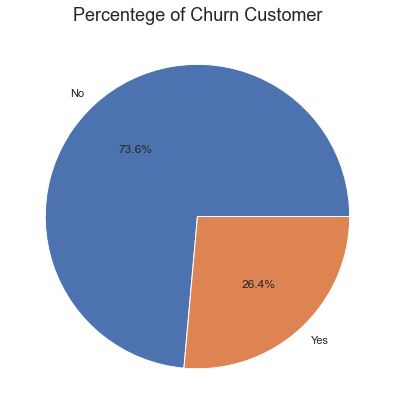

In [20]:
labels = ['No', 'Yes']
churn = df_load.Churn.value_counts()

plt.figure(figsize=(7,7))
plt.pie(churn, labels=labels, autopct='%1.1f%%')
plt.title('Percentege of Churn Customer', loc='center', fontsize=18)
plt.savefig('images/churn_percentege.png')
plt.show()

Berdasarkan plot tersebut dapat kita ketahui bahwa dari keseluruhan customer terdapat 26.4% customer yang melakukan *churn*.

### Exploring Numerical Columns

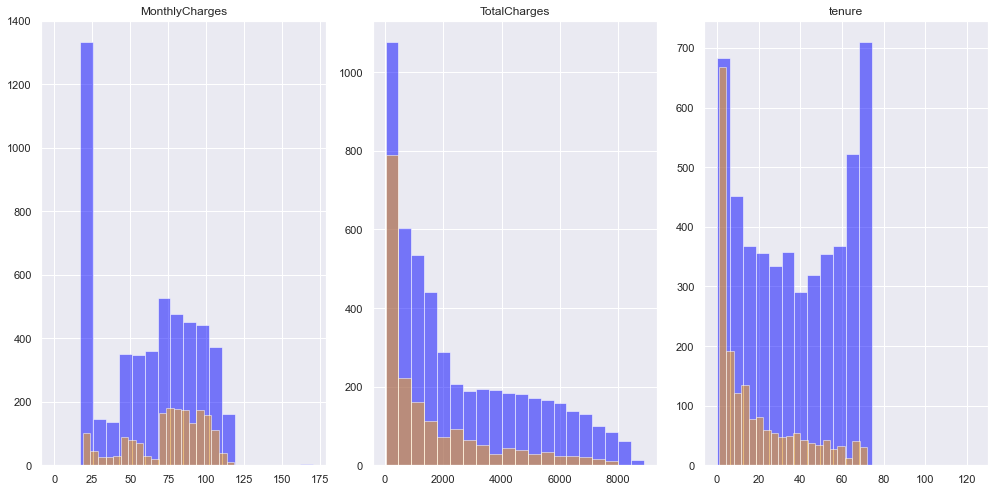

In [21]:
numerical_columns = ['MonthlyCharges','TotalCharges','tenure']
fig, ax = plt.subplots(1, 3, figsize=(14, 7))
df_load[df_load.Churn == 'No'][numerical_columns].hist(bins=20, 
                                                        color='blue', 
                                                        alpha=0.5, 
                                                        ax=ax)
df_load[df_load.Churn == 'Yes'][numerical_columns].hist(bins=20, 
                                                         color='orange', 
                                                         alpha=0.5, 
                                                         ax=ax)
plt.tight_layout()
plt.savefig('images/customer_by_age.png')
plt.show()

* Berdasarkan plot `MonthlyCharges` dapat kita ketahui bahwa semakin kecil biaya bulanan yang dikenakan, semakin kecil juga kecenderungan untuk melakukan *churn*
* Berdasarkan plot `TotalCharges` dapat dilihat bahwa tidak ada kecenderungan apapun terhadap *churn*
* Berdasarkan plot `tenure` dapat kita ketahui bahwa ada kecenderungan semakin lama berlangganan, semakin kecil kecenderungan untuk melakukan *churn*

### Exploring Categorical Columns

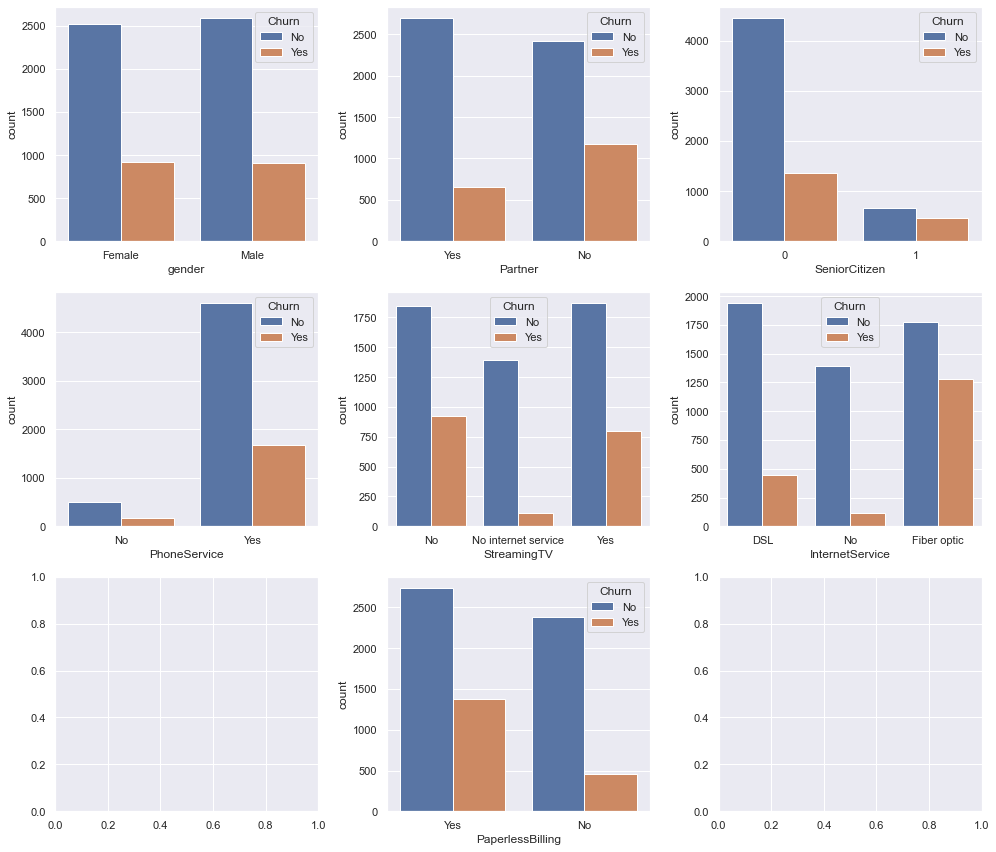

In [22]:
fig, ax = plt.subplots(3, 3, figsize=(14, 12))
sns.countplot(data=df_load, x='gender', hue='Churn', ax=ax[0][0])
sns.countplot(data=df_load, x='Partner', hue='Churn', ax=ax[0][1])
sns.countplot(data=df_load, x='SeniorCitizen', hue='Churn', ax=ax[0][2])
sns.countplot(data=df_load, x='PhoneService', hue='Churn', ax=ax[1][0])
sns.countplot(data=df_load, x='StreamingTV', hue='Churn', ax=ax[1][1])
sns.countplot(data=df_load, x='InternetService', hue='Churn', ax=ax[1][2])
sns.countplot(data=df_load, x='PaperlessBilling', hue='Churn', ax=ax[2][1])
plt.tight_layout()
plt.savefig('images/categorical_plot.png')
plt.show()

* Tidak ada perbedaan signifikan untuk melakukan *churn* jika dilihat faktor jenis kelamin (`gender`) dan layanan telfonnya (`PhoneSevice`)
* Ada kecenderungan melakukan *churn* untuk customer dengan kategori berikut:
    * Tidak memiliki partner (partner: No)
    * orang-orang yang statusnya adalah senior citizen (`SeniorCitizen: Yes`)
    * orang-orang yang mempunyai layanan streaming TV (`StreamingTV: Yes`)
    * orang-orang yang mempunyai layanan Internet (`internetService: Yes`)
    * orang-orang yang tagihannya paperless (`PaperlessBilling: Yes`)

## Data Preprocessing

### Removing Unnecessary Columns

In [23]:
cleaned_df = df_load.drop(['customerID', 'UpdatedAt'], axis=1)
cleaned_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1.0,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
4727,Male,0,Yes,No,60.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),20.50,1198.80,No
4738,Male,0,No,No,5.0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,No,Mailed check,104.10,541.90,Yes
4737,Female,0,Yes,No,72.0,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),115.50,8312.75,No
4736,Female,0,Yes,Yes,56.0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),81.25,4620.40,No


### Encoding Data

In [24]:
LE = LabelEncoder()

for column in cleaned_df.columns:
    if cleaned_df[column].dtype == np.number:
        continue
    else:
        cleaned_df[column] = LE.fit_transform(cleaned_df[column])

cleaned_df.describe()

<ipython-input-24-abc3fcdbd769>:4: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if cleaned_df[column].dtype == np.number:


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000
mean,0.504317,0.162302,0.483309,0.299281,32.423165,0.903741,0.940863,0.872950,0.789496,0.907194,0.904604,0.796115,0.985180,0.992950,0.690216,0.591942,1.576403,64.992201,2286.058750,0.264173
std,0.500017,0.368754,0.499757,0.457976,24.581073,0.294967,0.948880,0.737618,0.859795,0.880313,0.880037,0.861389,0.885069,0.885165,0.833363,0.491509,1.067780,30.032040,2265.702553,0.440923
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,36.462500,406.975000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.000000,70.450000,1400.850000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,89.850000,3799.837500,1.000000
max,1.000000,1.000000,1.000000,1.000000,124.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,169.931250,8889.131250,1.000000


### Spliting Dataset
Dataset akan dibagi menjadi 70% training & 30% testing

In [25]:
X = cleaned_df.drop('Churn', axis=1)
y = cleaned_df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# checking the shapes
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (4865, 19)
Shape of y_train: (4865,)
Shape of X_test: (2085, 19)
Shape of y_test: (2085,)


## Modelling

###  Model: Logistic Regression

In [26]:
log_model = LogisticRegression()
log_model = log_model.fit(X_train, y_train)

y_pred_train = log_model.predict(X_train)
y_pred = log_model.predict(X_test)

C:\Users\Rahmat\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Model Performance

In [27]:
print('Classification Report Logistic Regression Model (Data Training) :')

acc = round(accuracy_score(y_pred_train, y_train), 3)
precision = round(precision_score(y_pred_train,  y_train), 3)
recall = round(recall_score(y_pred_train,  y_train), 3)
f1 = round(f1_score(y_pred_train,  y_train), 3)

print('Accuracy: ', acc)
print('Precesion: ', precision)
print('Recall: ', recall)
print('F1: ', f1)

Classification Report Logistic Regression Model (Data Training) :
Accuracy:  0.8
Precesion:  0.567
Recall:  0.637
F1:  0.6


In [28]:
print('Classification Report Logistic Regression Model :')

acc = round(accuracy_score(y_pred, y_test), 3)
precision = round(precision_score(y_pred,  y_test), 3)
recall = round(recall_score(y_pred,  y_test), 3)
f1 = round(f1_score(y_pred,  y_test), 3)

print('Accuracy: ', acc)
print('Precesion: ', precision)
print('Recall: ', recall)
print('F1: ', f1)

Classification Report Logistic Regression Model :
Accuracy:  0.808
Precesion:  0.544
Recall:  0.661
F1:  0.597


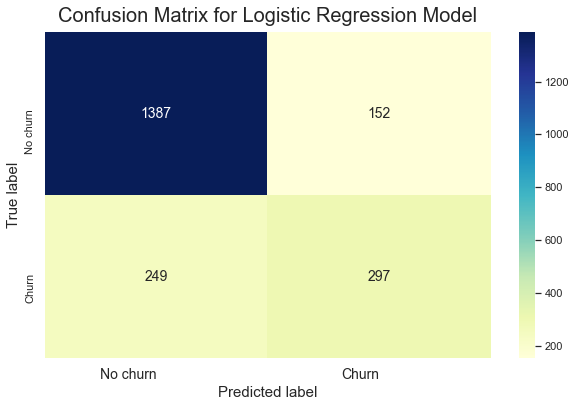

In [29]:
cnf_matrix = confusion_matrix(y_test, y_pred)

labels = ('No churn', 'Churn')

confusion_matrix_df = pd.DataFrame(cnf_matrix, labels, labels)

# Plot confusion matrix
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.title('Confusion Matrix for Logistic Regression Model', fontsize=20, pad=10)
plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.savefig('images/snf_log_model.png')
plt.show()

### Model: Random Forest Classifier

In [30]:
rdf_model = RandomForestClassifier()
rdf_model = rdf_model.fit(X_train, y_train)

y_pred_train = rdf_model.predict(X_train)
y_pred = rdf_model.predict(X_test)

#### Model Performance

In [31]:
print('Classification Report Random Forest Classifier (Data Training) :')
acc = round(accuracy_score(y_pred_train, y_train), 3)
precision = round(precision_score(y_pred_train,  y_train), 3)
recall = round(recall_score(y_pred_train,  y_train), 3)
f1 = round(f1_score(y_pred_train,  y_train), 3)

print('Accuracy: ', acc)
print('Precesion: ', precision)
print('Recall: ', recall)
print('F1: ', f1)

Classification Report Random Forest Classifier (Data Training) :
Accuracy:  0.998
Precesion:  0.995
Recall:  0.996
F1:  0.995


In [32]:
print('Classification Report Random Forest Classifier:')
acc = round(accuracy_score(y_pred, y_test), 3)
precision = round(precision_score(y_pred,  y_test), 3)
recall = round(recall_score(y_pred,  y_test), 3)
f1 = round(f1_score(y_pred,  y_test), 3)

print('Accuracy: ', acc)
print('Precesion: ', precision)
print('Recall: ', recall)
print('F1: ', f1)

Classification Report Random Forest Classifier:
Accuracy:  0.796
Precesion:  0.476
Recall:  0.65
F1:  0.55


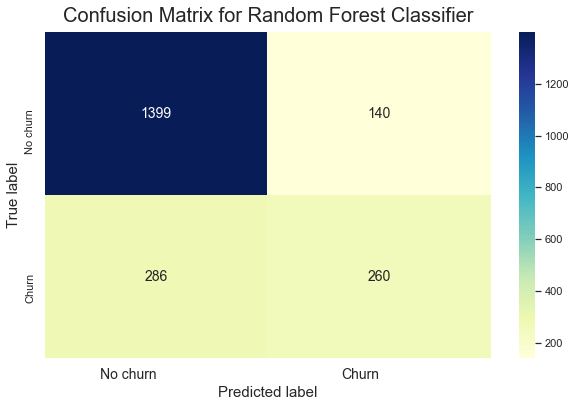

In [33]:
cnf_matrix = confusion_matrix(y_test, y_pred)

labels = ('No churn', 'Churn')

confusion_matrix_df = pd.DataFrame(cnf_matrix, labels, labels)

# Plot confusion matrix
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.title('Confusion Matrix for Random Forest Classifier', fontsize=20, pad=10)
plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.savefig('images/snf_cnf_model.png')
plt.show()

### Model: Gradient Boosting Classifier

In [34]:
gbt_model = GradientBoostingClassifier()
gbt_model = gbt_model.fit(X_train, y_train)

y_pred_train = gbt_model.predict(X_train)
y_pred = gbt_model.predict(X_test)

#### Model Performance

In [35]:
print('Classification Report Gradient Boosting Classifier (Data Training) :')
acc = round(accuracy_score(y_pred_train, y_train), 3)
precision = round(precision_score(y_pred_train,  y_train), 3)
recall = round(recall_score(y_pred_train,  y_train), 3)
f1 = round(f1_score(y_pred_train,  y_train), 3)

print('Accuracy: ', acc)
print('Precesion: ', precision)
print('Recall: ', recall)
print('F1: ', f1)

Classification Report Gradient Boosting Classifier (Data Training) :
Accuracy:  0.831
Precesion:  0.579
Recall:  0.727
F1:  0.645


In [36]:
print('Classification Report Gradient Boosting Classifier:')
acc = round(accuracy_score(y_pred, y_test), 3)
precision = round(precision_score(y_pred,  y_test), 3)
recall = round(recall_score(y_pred,  y_test), 3)
f1 = round(f1_score(y_pred,  y_test), 3)

print('Accuracy: ', acc)
print('Precesion: ', precision)
print('Recall: ', recall)
print('F1: ', f1)

Classification Report Gradient Boosting Classifier:
Accuracy:  0.81
Precesion:  0.515
Recall:  0.682
F1:  0.587


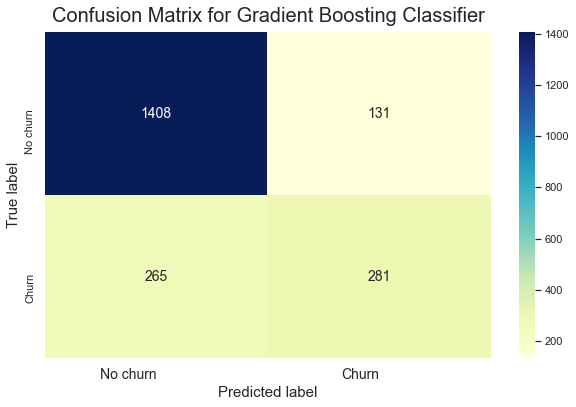

In [37]:
cnf_matrix = confusion_matrix(y_test, y_pred)

labels = ('No churn', 'Churn')

confusion_matrix_df = pd.DataFrame(cnf_matrix, labels, labels)

# Plot confusion matrix
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.title('Confusion Matrix for Gradient Boosting Classifier', fontsize=20, pad=10)
plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.savefig('images/snf_gbt_model.png')
plt.show()

### Model: KNN Classifier

In [38]:
knn = KNeighborsClassifier()
knn = knn.fit(X_train, y_train)

y_pred_train = gbt_model.predict(X_train)
y_pred = gbt_model.predict(X_test)

#### Model Performance

In [39]:
print('Classification Report KNN Classifier Model (Data Training) :')
acc = round(accuracy_score(y_pred_train, y_train), 3)
precision = round(precision_score(y_pred_train,  y_train), 3)
recall = round(recall_score(y_pred_train,  y_train), 3)
f1 = round(f1_score(y_pred_train,  y_train), 3)

print('Accuracy: ', acc)
print('Precesion: ', precision)
print('Recall: ', recall)
print('F1: ', f1)

Classification Report KNN Classifier Model (Data Training) :
Accuracy:  0.831
Precesion:  0.579
Recall:  0.727
F1:  0.645


In [40]:
print('Classification Report KNN Classifier:')
acc = round(accuracy_score(y_pred, y_test), 3)
precision = round(precision_score(y_pred,  y_test), 3)
recall = round(recall_score(y_pred,  y_test), 3)
f1 = round(f1_score(y_pred,  y_test), 3)

print('Accuracy: ', acc)
print('Precesion: ', precision)
print('Recall: ', recall)
print('F1: ', f1)

Classification Report KNN Classifier:
Accuracy:  0.81
Precesion:  0.515
Recall:  0.682
F1:  0.587


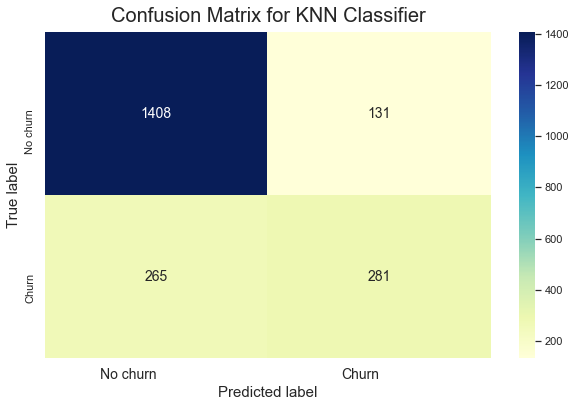

In [41]:
cnf_matrix = confusion_matrix(y_test, y_pred)

labels = ('No churn', 'Churn')

confusion_matrix_df = pd.DataFrame(cnf_matrix, labels, labels)

# Plot confusion matrix
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.title('Confusion Matrix for KNN Classifier', fontsize=20, pad=10)
plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.savefig('images/snf_knn_model.png')
plt.show()

## Conclusion

- Dari keseluruhan customer terdapat 26.4% customer yang melakukan churn\
- Biaya bulanan memiliki pengaruh terhadap kecenderungan kustomer melakukan churn, dimana semakin kecil biaya bulanan yang dikenakan maka semakin kecil juga kecenderungan untuk melakukan churn. Selain itu, customer yang telah berlangganan dalam waktu yang lama memiliki kecenderungan yang kecil untuk melakukan churn.
- Ada kecenderungan melakukan *churn* untuk customer dengan kategori berikut:
    * Tidak memiliki partner (partner: No)
    * orang-orang yang statusnya adalah senior citizen (`SeniorCitizen: Yes`)
    * orang-orang yang mempunyai layanan streaming TV (`StreamingTV: Yes`)
    * orang-orang yang mempunyai layanan Internet (`internetService: Yes`)
    * orang-orang yang tagihannya paperless (`PaperlessBilling: Yes`)
- Berdasarkan pemodelan yang telah dilakukan dengan menggunakan empat jenis model yang berbeda, maka dapat disimpulkan untuk memprediksi churn customer dengan menggunakan dataset ini model terbaiknya adalah menggunakan algortima Logistic Regression.